# Distribution-based feature extraction from whole-genome data

The following notebook presents the reproducible code for analyzing the quality of automatically extracted classification features from whole-genome VCF files. The code contains comments concerning each step of the analysis that served as the basis for the paper **Distribution-based feature extraction from whole-genome data** by Piernik *et al.*

The analysis was coded with Python 3.7.9. The environment specification is provided in the `requirements.txt` in the root of the GitHub repository (https://github.com/MNMdiagnostics/distribution_based_features). Utility methods used in this analysis can by found in the `experiment_utils.py` file.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML

# main DBFE module
from dbfe import DistributionBasedFeatureExtractor
# utility methods to make this notebook shorter
from experiment_util import *

The global parameters of the analysis are presented below. We will analyze how distribution based features can be used to classify ovarian, lung, and breast cancer patients. Ovarian cancer patients were labeled as responders/non-responders to platinium-based or poly (ADP-ribose) polymerase inhibitor (PARPi) therapy, lung cancer patients were labeled as responders/non-responders to immutherapy, and breast cancer patients were labeled according to their subtype: HER2+, ER+ HER2-, triple negative breast cancer (TNBC). 

From these samples we extracted three types of copy number variations (CNVs): deletions (DEL), diploids (DIP), duplications (DUP), and three types of structural variants (SVs): inversions (INV), deletions (DEL), tandem duplications (DUP)). Lengths of those CNVs and SVs are treated as input to our distribution-based feature extraction (DBFE) approaches, and then passed to classifiers. In our experiments, we compare how DBFE features affect four  types of classifiers: Random Forest (RF), Naive Bayes (NB), Logistic Regression (LR), k-Nearest Neighbors (kNN).

The datasets will be split into training and testing in proportions 70%, 30%, respectively. Sensitivity tests will be performed only on the training tests, using 2 repetitions of 5-fold cross-validation (2x5 CV). The result files and figures will be saved to the `results` folder.

In [2]:
HOLDOUT_SIZE = 0.3
SEED = 23 # Michael Jordan
CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=SEED)
RESULTS_FOLDER = "results"

CANCERS = [('lung', ['RES', 'NONRES']), ('ovarian', ['RES', 'NONRES']), 
           ('breast', ['HER2+', 'ER+ HER2-']), ('breast', ['HER2+', 'TNBC']), ('breast', ['ER+ HER2-', 'TNBC'])]
VARIANTS = [('cnv', 'del'), ('cnv', 'dip'), ('cnv', 'dup'), ('sv', 'inv'), ('sv', 'del'), ('sv', 'dup')]
METHODS = ['quantile', 'clustering', 'supervised']
ALGORITHMS = {
    "RF": RandomForestClassifier(random_state=SEED),
    "NB": GaussianNB(),
    "LR": LogisticRegression(random_state=SEED),
    "kNN": KNeighborsClassifier(),
}
CLUSTER_COLORS = ['#648FFF', '#FFB000', '#DC267F']
SUBTYPE_COLORS = ['#4477aa', '#ee6677', '#228833']
COLOR_MAPPING = {0: '#648FFF', 1: '#FFB000', 2: '#DC267F'}

## Datasets

Experiments were performed on 3 sets of genomic samples for patients with ovarian, breast, or lung cancer, respectively. Samples were taken from [The Cancer Genome Atlas](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga), [Hartwig Medical Foundation](https://www.hartwigmedicalfoundation.nl/en/database/) and the [International Cancer Genome Consortium](https://dcc.icgc.org/) and selected to have clinical response to a given treatment. For each sample we calculated the lengths of copy number variants (CNVs), structural variants (SVs). The lengths and positions of these can be found in the `data` folder in csv format (extracted from ASCAT and Manta VCF files).

The functions below will be used to read the selected class (DEL, DUP, DIP, INV) of a structural variant type (CNV, SV) for a selected cancer type (ovarian, breast, lung), and to split them into training and testing sets.

Below the first rows of the CNV DEL data for ovarian cancer patients.

In [3]:
dataset = get_dataset('ovarian', 'cnv', 'del', ['NONRES', 'RES'], pos_class='RES')

dataset.head()

LEN  COUNT  \
CPCT02010646T  [339068, 99019, 124463, 75553, 157365, 88249, ...     18   
CPCT02010679T  [28911668, 90828442, 174326, 162267, 30594, 77...     45   
CPCT02020307T  [1776581, 124818, 716325, 7281449, 2640338, 36...     18   
CPCT02020333T  [767016, 1689640, 28817694, 28186777, 1394127,...     38   
CPCT02020420T  [2366861, 10411937, 59616662, 44211, 13166450,...     31   

               CLASS_LABEL  
CPCT02010646T            0  
CPCT02010679T            0  
CPCT02020307T            1  
CPCT02020333T            1  
CPCT02020420T            0

The list of datasets used in the analysis is presented below.

In [4]:
dataset_sizes = pd.DataFrame()

for cancer in [('lung', ['RES', 'NONRES']), ('ovarian', ['RES', 'NONRES']), ('breast', ['HER2+', 'ER+ HER2-', 'TNBC'])]:
    for variant in VARIANTS:
        dataset = get_dataset(cancer[0], variant[0], variant[1], cancer[1], pos_class=cancer[1][0])
        dataset_sizes = dataset_sizes.append({"cancer_type":cancer[0], "allowed_classes": str(cancer[1]), 
                                              "variant_group": variant[0],  "variant_type": variant[1], 
                                              "samples": dataset.shape[0]}, ignore_index=True)
        
dataset_sizes.loc[:, ["allowed_classes", "cancer_type", "samples"]].groupby(["allowed_classes", "cancer_type"]).max()

samples
allowed_classes                cancer_type         
['HER2+', 'ER+ HER2-', 'TNBC'] breast         811.0
['RES', 'NONRES']              lung            61.0
                               ovarian        144.0

## Example visualizations of DBFE methods

Below are visualizations of each DBFE approach with samples of extracted features. The code below was the basis for creating Fig. 1 in the associated paper.

dbfe_0_61912  dbfe_61912_288664  dbfe_288664_4757030  \
TCGA-36-1570-01A            19                  8                    3   
TCGA-36-1571-01A             2                  4                   10   
TCGA-36-1574-01A            15                  8                   22   
TCGA-61-2000-01A             3                  5                    1   
TCGA-61-2095-01A            15                  6                    8   

                  dbfe_4757030_inf  total_dbfe  frac_dbfe_0_61912  \
TCGA-36-1570-01A                27          57           0.333333   
TCGA-36-1571-01A                 3          19           0.105263   
TCGA-36-1574-01A                28          73           0.205479   
TCGA-61-2000-01A                 0           9           0.333333   
TCGA-61-2095-01A                 6          35           0.428571   

                  frac_dbfe_61912_288664  frac_dbfe_288664_4757030  \
TCGA-36-1570-01A                0.140351                  0.052632   
TCGA-36-1571-01A                0.210526                  0.526316   
TCGA-36-1574-01A                0.109589                  0.301370   
TCGA-61-2000-01A                0.555556                  0.111111   
TCGA-61-2095-01A                0.171429                  0.228571   

                  frac_dbfe_4757030_inf  CLASS_LABEL  
TCGA-36-1570-01A               0.473684            1  
TCGA-36-1571-01A               0.157895            1  
TCGA-36-1574-01A               0.383562            1  
TCGA-61-2000-01A               0.000000            0  
TCGA-61-2095-01A               0.171429            0

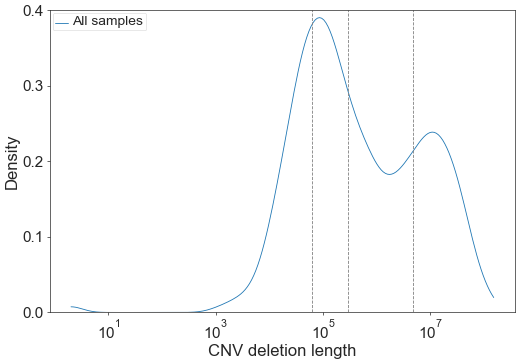

In [31]:
dataset = get_dataset('ovarian', 'cnv', 'del', ['NONRES', 'RES'], pos_class='RES')
plot_dataset = dataset.copy()
plot_dataset.loc[:, "CLASS_LABEL"] = 0

plt.rcParams['figure.dpi'] = 50
display(HTML("<style>table {whitespace: pre;}</style>"))
extractor = paper_ready_dbfe_plot(plot_dataset, dataset, "quantile", 4, ['All samples'], 
                                  'CNV deletion length', "quantile", RESULTS_FOLDER);

dbfe_0_184957  dbfe_184957_1274651  dbfe_1274651_18223199  \
TCGA-36-1570-01A             25                    3                     17   
TCGA-36-1571-01A              5                    6                      7   
TCGA-36-1574-01A             23                    8                     30   
TCGA-61-2000-01A              8                    1                      0   
TCGA-61-2095-01A             20                    6                      8   

                  dbfe_18223199_inf  total_dbfe  frac_dbfe_0_184957  \
TCGA-36-1570-01A                 12          57            0.438596   
TCGA-36-1571-01A                  1          19            0.263158   
TCGA-36-1574-01A                 12          73            0.315068   
TCGA-61-2000-01A                  0           9            0.888889   
TCGA-61-2095-01A                  1          35            0.571429   

                  frac_dbfe_184957_1274651  frac_dbfe_1274651_18223199  \
TCGA-36-1570-01A                  0.052632                    0.298246   
TCGA-36-1571-01A                  0.315789                    0.368421   
TCGA-36-1574-01A                  0.109589                    0.410959   
TCGA-61-2000-01A                  0.111111                    0.000000   
TCGA-61-2095-01A                  0.171429                    0.228571   

                  frac_dbfe_18223199_inf  CLASS_LABEL  
TCGA-36-1570-01A                0.210526            1  
TCGA-36-1571-01A                0.052632            1  
TCGA-36-1574-01A                0.164384            1  
TCGA-61-2000-01A                0.000000            0  
TCGA-61-2095-01A                0.028571            0

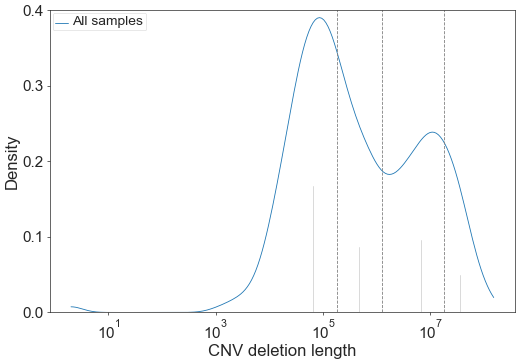

In [22]:
extractor = paper_ready_dbfe_plot(plot_dataset, dataset, "clustering", 4, ['All samples'],
                                  'CNV deletion length', "clustering", RESULTS_FOLDER);

dbfe_27558_1828481  dbfe_1828481_132905545  total_dbfe  \
TCGA-36-1570-01A                  20                      29          57   
TCGA-36-1571-01A                  13                       5          19   
TCGA-36-1574-01A                  21                      42          73   
TCGA-61-2000-01A                   8                       0           9   
TCGA-61-2095-01A                  18                       6          35   

                  frac_dbfe_27558_1828481  frac_dbfe_1828481_132905545  \
TCGA-36-1570-01A                 0.350877                     0.508772   
TCGA-36-1571-01A                 0.684211                     0.263158   
TCGA-36-1574-01A                 0.287671                     0.575342   
TCGA-61-2000-01A                 0.888889                     0.000000   
TCGA-61-2095-01A                 0.514286                     0.171429   

                  CLASS_LABEL  
TCGA-36-1570-01A            1  
TCGA-36-1571-01A            1  
TCGA-36-1574-01A            1  
TCGA-61-2000-01A            0  
TCGA-61-2095-01A            0

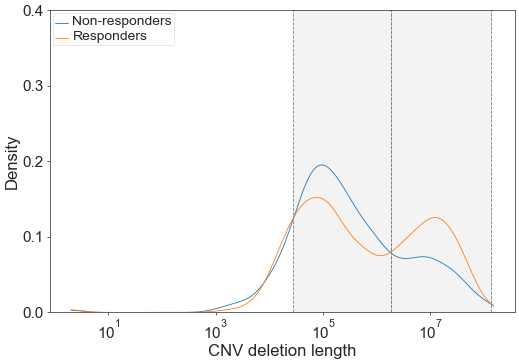

In [23]:
extractor = paper_ready_dbfe_plot(dataset, dataset, "supervised", "auto", ['Non-responders', 'Responders'], 
                                  'CNV deletion length', "supervised", RESULTS_FOLDER);

## Sensitivity analysis

Here we analyze the sensitivity of the proposed feature extraction methods to different parameter values. Sensitivity will be evaluated based on the predictive performance of four different classifiers:
- Logistic Regression (LR)
- Naive Bayes (NB)
- Random Forest (RF)
- k-Nearest Neighbors (kNN)

We will experiment with four parameters:
1. Extracting counts, fractions, or both as features
2. The KDE bandwidth used in the KDE approach
3. The only peaks option in the KDE approach
4. CV-smoothing in the KDE approach
5. The max number of features produced by quantile binning and clustering

### Counts vs fractions

All the DBFE approaches can be used to produce features that are counts or fractions of variants of a given length. Here, we verify whether counts fractions, or the combination of both provide the best predictive capabilities.

In [22]:
param_sets = [
    {"include_counts": True, "include_fracs": False, "include_total": True}, 
    {"include_counts": False, "include_fracs": True, "include_total": True}, 
    {"include_counts": True, "include_fracs": True, "include_total": True}
]
bandwidth_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, METHODS, ALGORITHMS,
                                                                                    CV, "fracs_counts", param_sets,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    bandwidth_sensitivity = bandwidth_sensitivity.append(results_cancer_type)
    bandwidth_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'fracs_counts_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

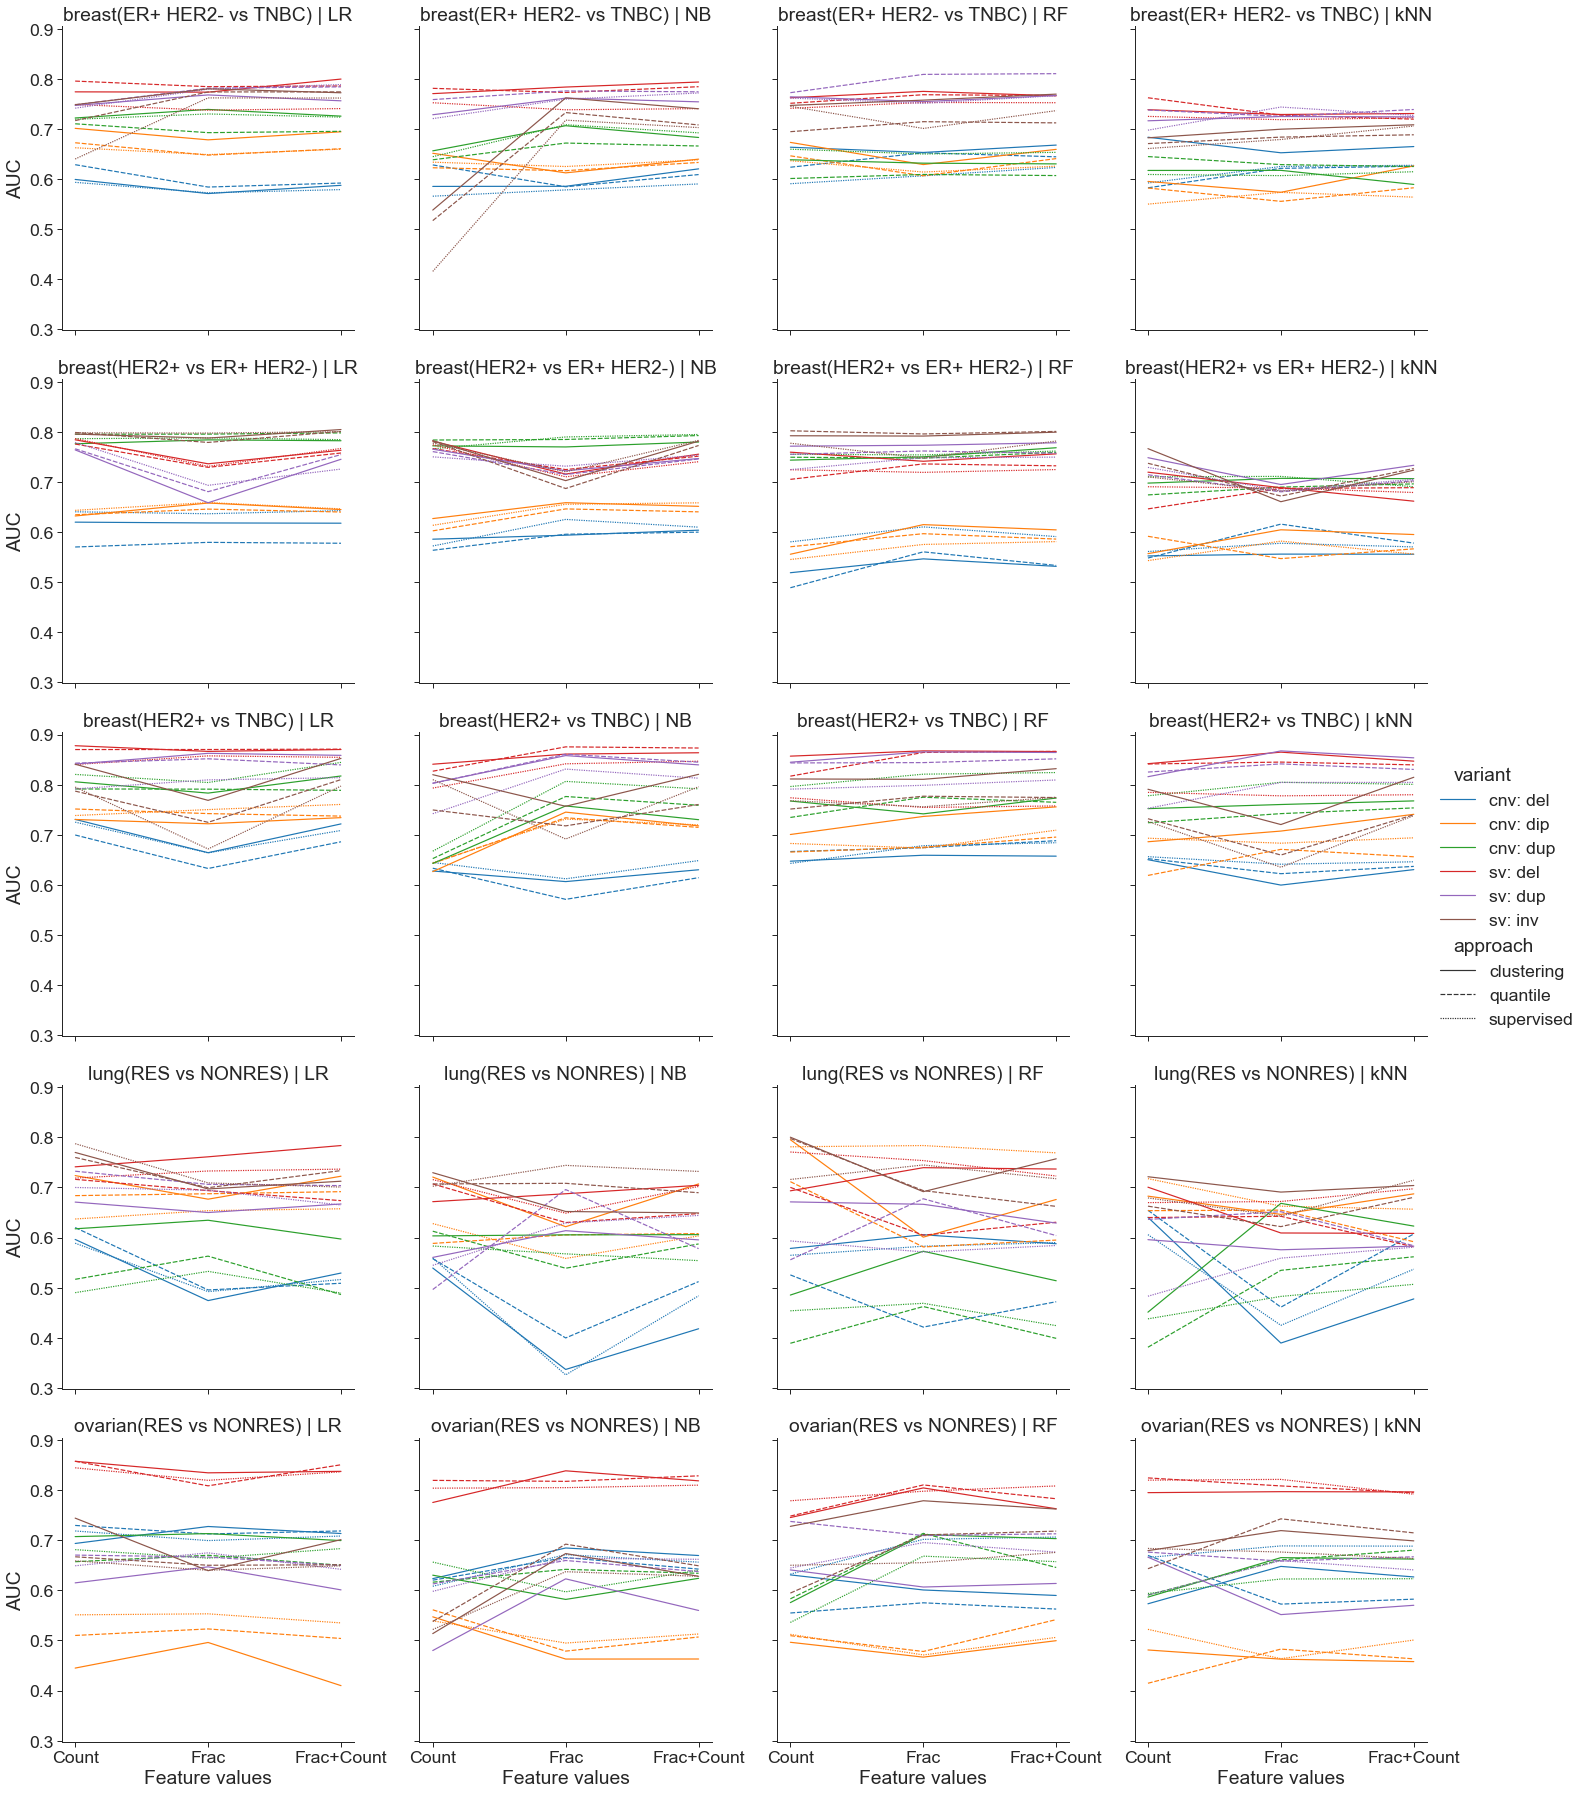

In [3]:
fracs_counts_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'fracs_counts_sensitivity.csv'), index_col=None)
fracs_counts_sensitivity_df.fracs_counts = fracs_counts_sensitivity_df.fracs_counts.map({
    "{'include_counts': True, 'include_fracs': False, 'include_total': True}": "Count", 
    "{'include_counts': False, 'include_fracs': True, 'include_total': True}": "Frac", 
    "{'include_counts': True, 'include_fracs': True, 'include_total': True}": "Frac+Count",
    "{'include_counts': True, 'include_fracs': False, 'include_total': True, 'n_bins': 'auto'}": "Count", 
    "{'include_counts': False, 'include_fracs': True, 'include_total': True, 'n_bins': 'auto'}": "Frac", 
    "{'include_counts': True, 'include_fracs': True, 'include_total': True, 'n_bins': 'auto'}": "Frac+Count"})
fracs_counts_sensitivity_df = fracs_counts_sensitivity_df.rename(columns={"fracs_counts": "Feature values"})
plot_sensitivity_results(fracs_counts_sensitivity_df, "Feature values", RESULTS_FOLDER, "fracs_counts")

As can be noticed on the above plot, using both fraction and counts together offers the best results. Depending on the dataset and variant type, using both counts and fractions either offers the best predictive performance or a good compromise between using only one of these representations. These results are confirmed by a series of Friedman and Nemenyi post-hoc tests.

In [5]:
calculate_param_tests(fracs_counts_sensitivity_df, "Feature values", "AUROC")

Approach:  quantile , Classifier:  RF
Count  mean value:  0.6682
Frac  mean value:  0.6802
Frac+Count  mean value:  0.6772
Test p-value for AUROC: 0.0

Nemenyi post-hoc
            Count   Frac  Frac+Count
Count       1.000  0.001       0.001
Frac        0.001  1.000       0.900
Frac+Count  0.001  0.900       1.000

Approach:  quantile , Classifier:  NB
Count  mean value:  0.6649
Frac  mean value:  0.6792
Frac+Count  mean value:  0.6855
Test p-value for AUROC: 0.0001

Nemenyi post-hoc
               Count      Frac  Frac+Count
Count       1.000000  0.184959    0.001000
Frac        0.184959  1.000000    0.028899
Frac+Count  0.001000  0.028899    1.000000

Approach:  quantile , Classifier:  LR
Count  mean value:  0.7159
Frac  mean value:  0.6987
Frac+Count  mean value:  0.7058
Test p-value for AUROC: 0.0

Nemenyi post-hoc
               Count      Frac  Frac+Count
Count       1.000000  0.001000    0.184959
Frac        0.001000  1.000000    0.024377
Frac+Count  0.184959  0.024377    1.000

### KDE approach: bandwidth

For the supervised approach we also checked how the classifiers perform if the features are extracted from kernel density estimations with different bandwidth.

In [10]:
param_name = "bw"
param_values = np.linspace(0.05, 1.5, 30)
bandwidth_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    bandwidth_sensitivity = bandwidth_sensitivity.append(results_cancer_type)
    bandwidth_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

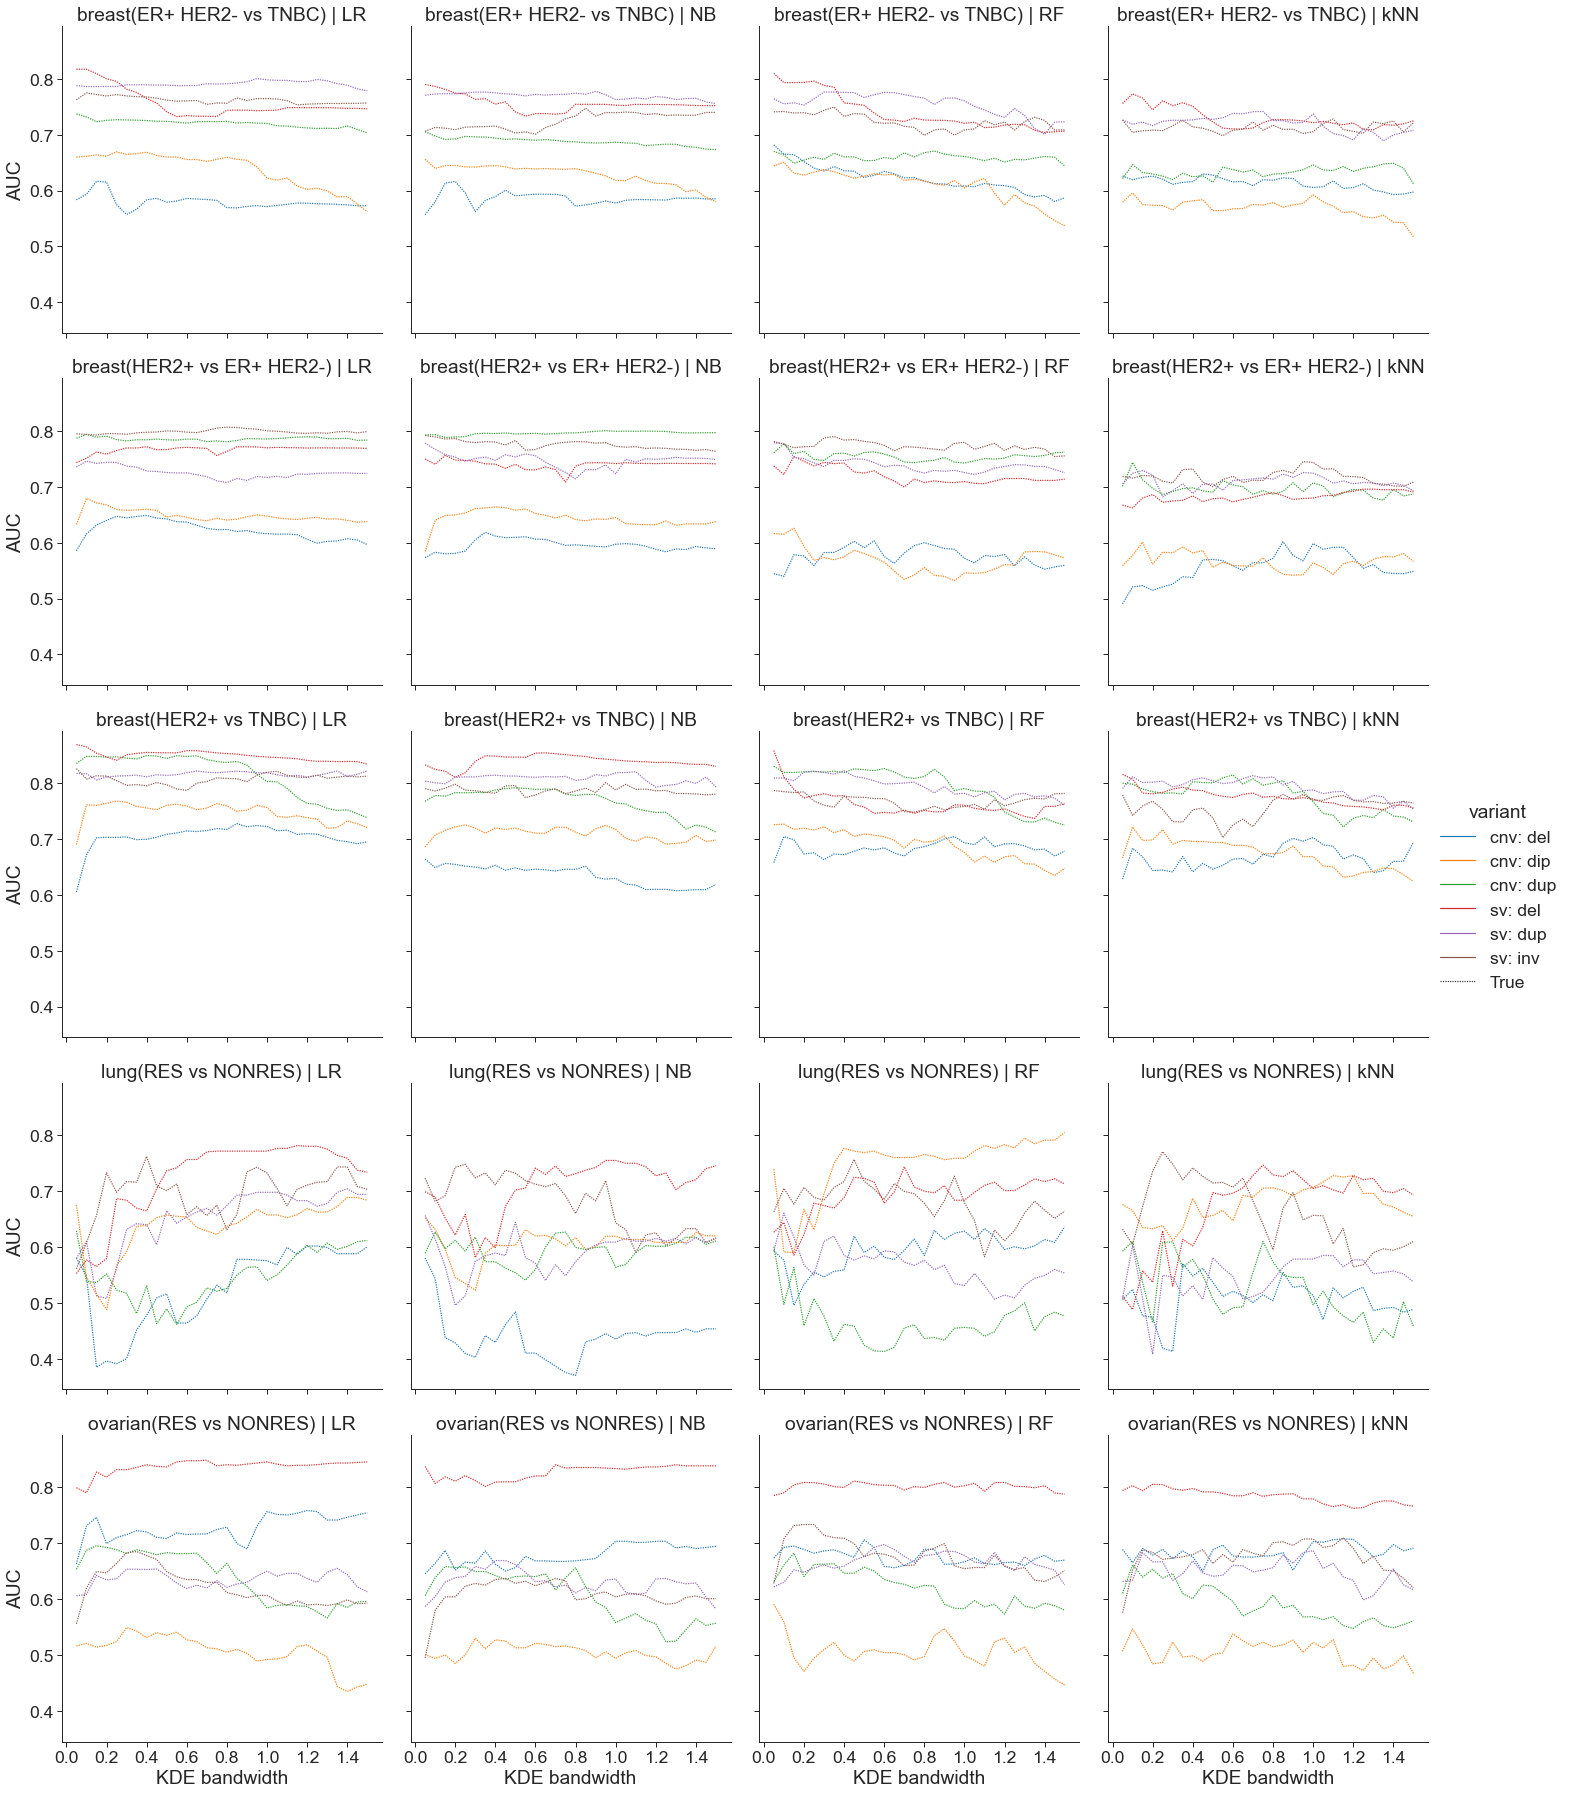

In [5]:
bandwidth_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index_col=None)
bandwidth_sensitivity_df = bandwidth_sensitivity_df.rename(columns={"bw": "KDE bandwidth"})
plot_sensitivity_results(bandwidth_sensitivity_df, "KDE bandwidth", RESULTS_FOLDER, "bw", style=True, dashes=[(1,1)])

As can be noticed on the plot above, bandwidth can have a significant impact on classifier performance. Depending on the dataset and variant type, classifier performance usually either slowly degrades with growing bandwidth or rapidly increases and stabilized. Therefore, the default value of KDE bandwidth was set to 0.5. However, for best performance KDE bandwidth in the supervised approach should be tuned for each dataset.

### KDE approach: only peaks

In [12]:
param_name = "only_peaks"
param_values = [True, False]
only_peaks_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    only_peaks_sensitivity = only_peaks_sensitivity.append(results_cancer_type)
    only_peaks_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

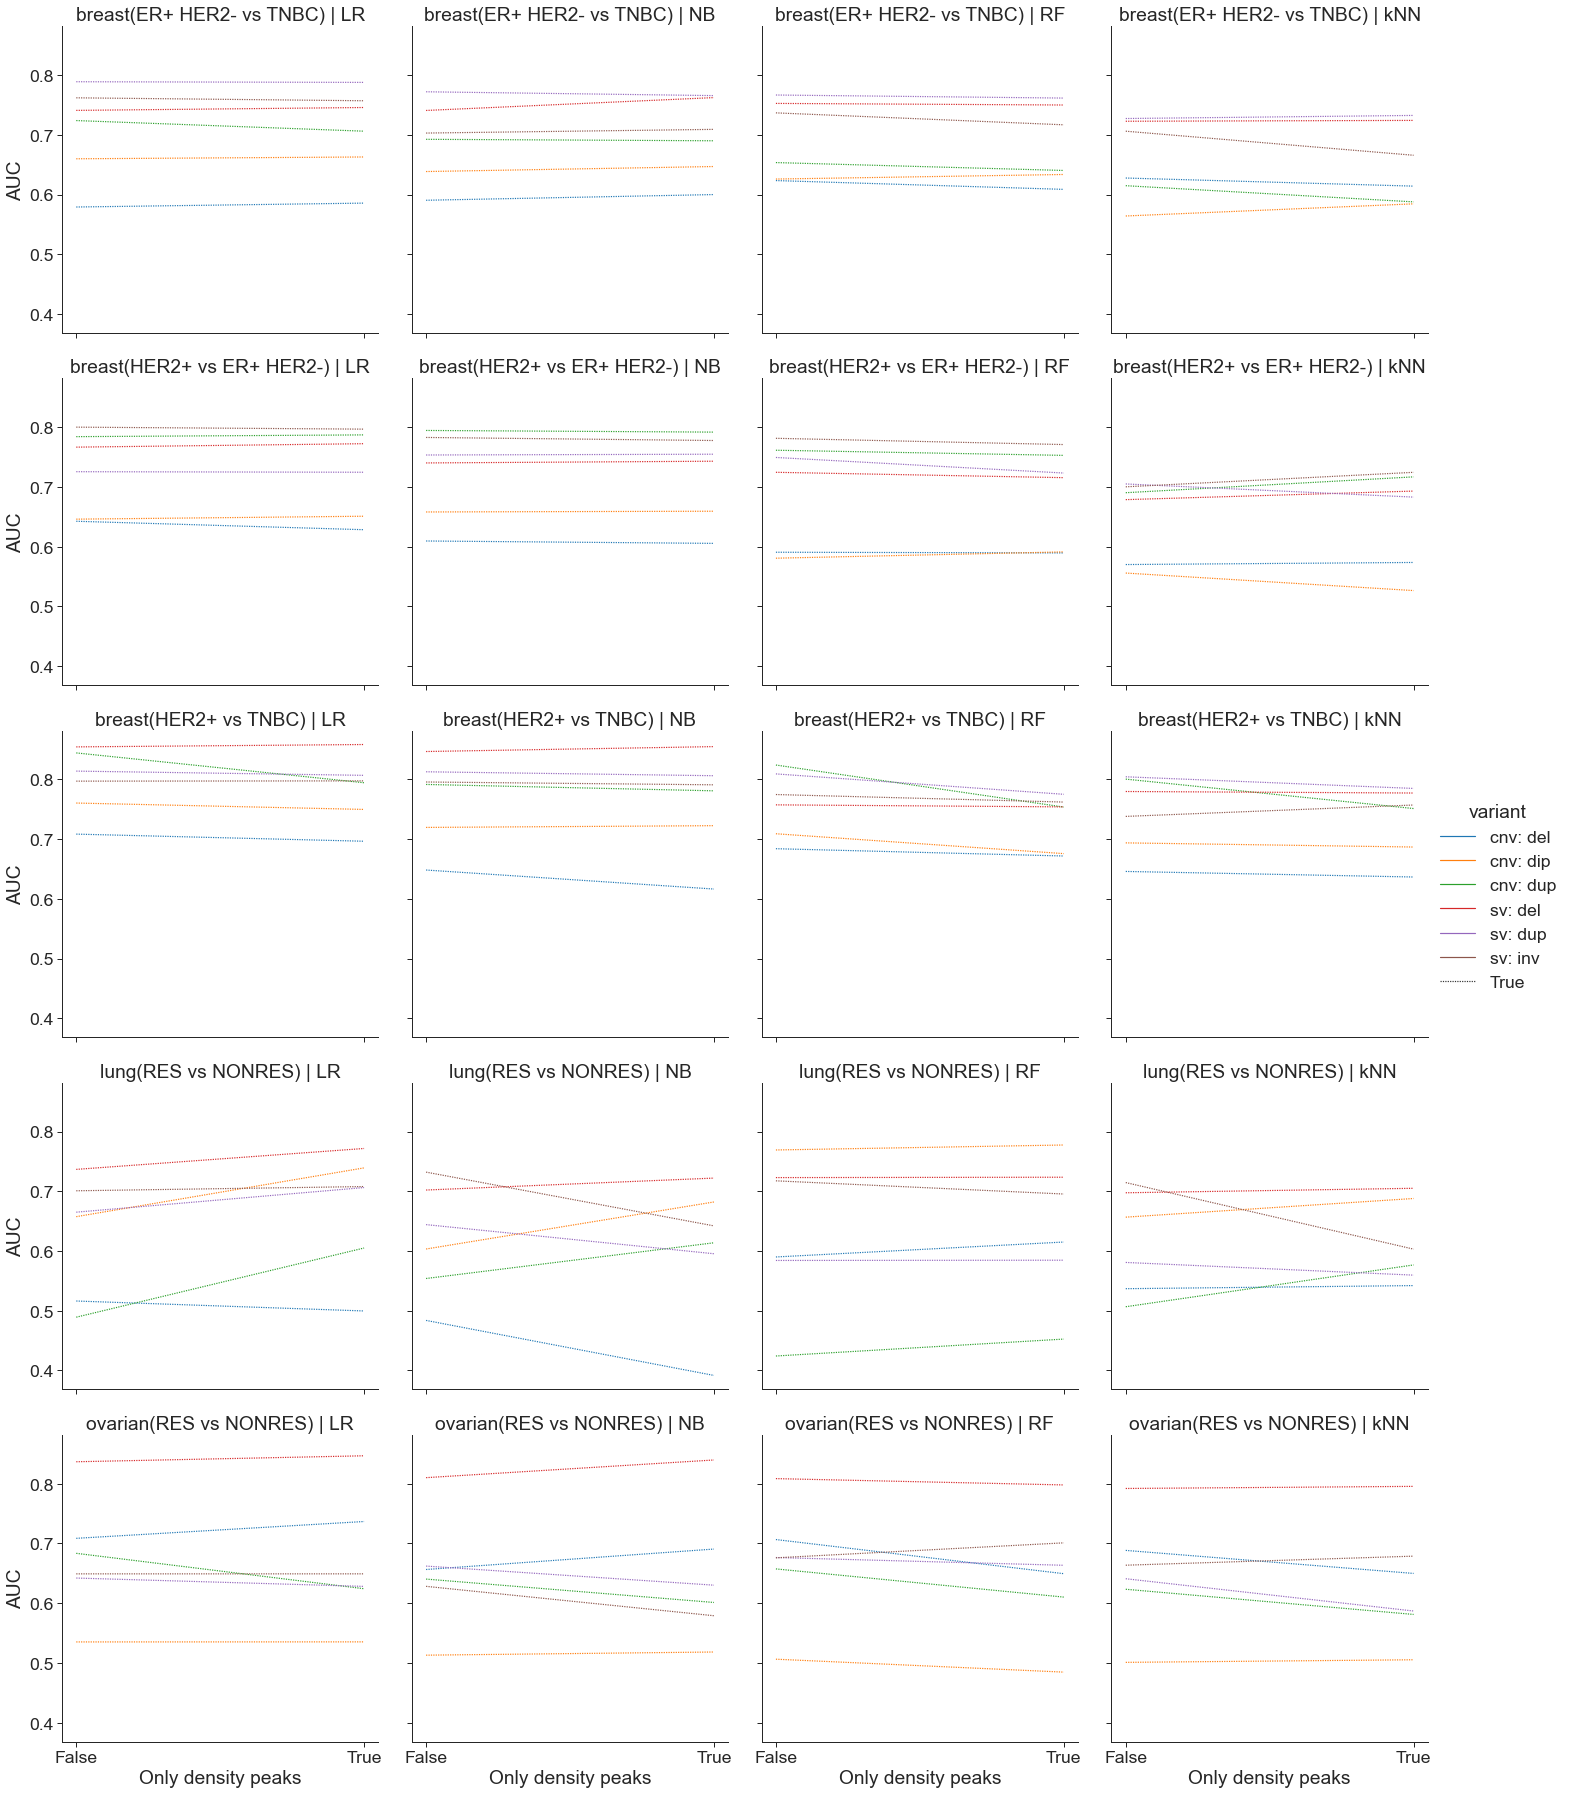

In [6]:
only_peaks_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index_col=None)
only_peaks_sensitivity_df.only_peaks = only_peaks_sensitivity_df.only_peaks.map({True: "True", False: "False"})
only_peaks_sensitivity_df = only_peaks_sensitivity_df.rename(columns={"only_peaks": "Only density peaks"})
plot_sensitivity_results(only_peaks_sensitivity_df, "Only density peaks", RESULTS_FOLDER, "only_peaks", style=True, dashes=[(1,1)])

In [9]:
calculate_param_tests(only_peaks_sensitivity_df, "Only density peaks", "AUROC", test=wilcoxon, post_hoc=False)

Approach:  supervised , Classifier:  RF
True  mean value:  0.6801
False  mean value:  0.6915
Test p-value for AUROC: 0.0001


Approach:  supervised , Classifier:  NB
True  mean value:  0.6861
False  mean value:  0.6907
Test p-value for AUROC: 0.406


Approach:  supervised , Classifier:  LR
True  mean value:  0.712
False  mean value:  0.7073
Test p-value for AUROC: 0.5655


Approach:  supervised , Classifier:  kNN
True  mean value:  0.6564
False  mean value:  0.6642
Test p-value for AUROC: 0.0797




### KDE approach: cross-validation smoothing

In [15]:
param_name = "cv"
param_values = [None, 2, 3, 5, 7, 10]
cv_smoothing_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    cv_smoothing_sensitivity = cv_smoothing_sensitivity.append(results_cancer_type)
    cv_smoothing_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

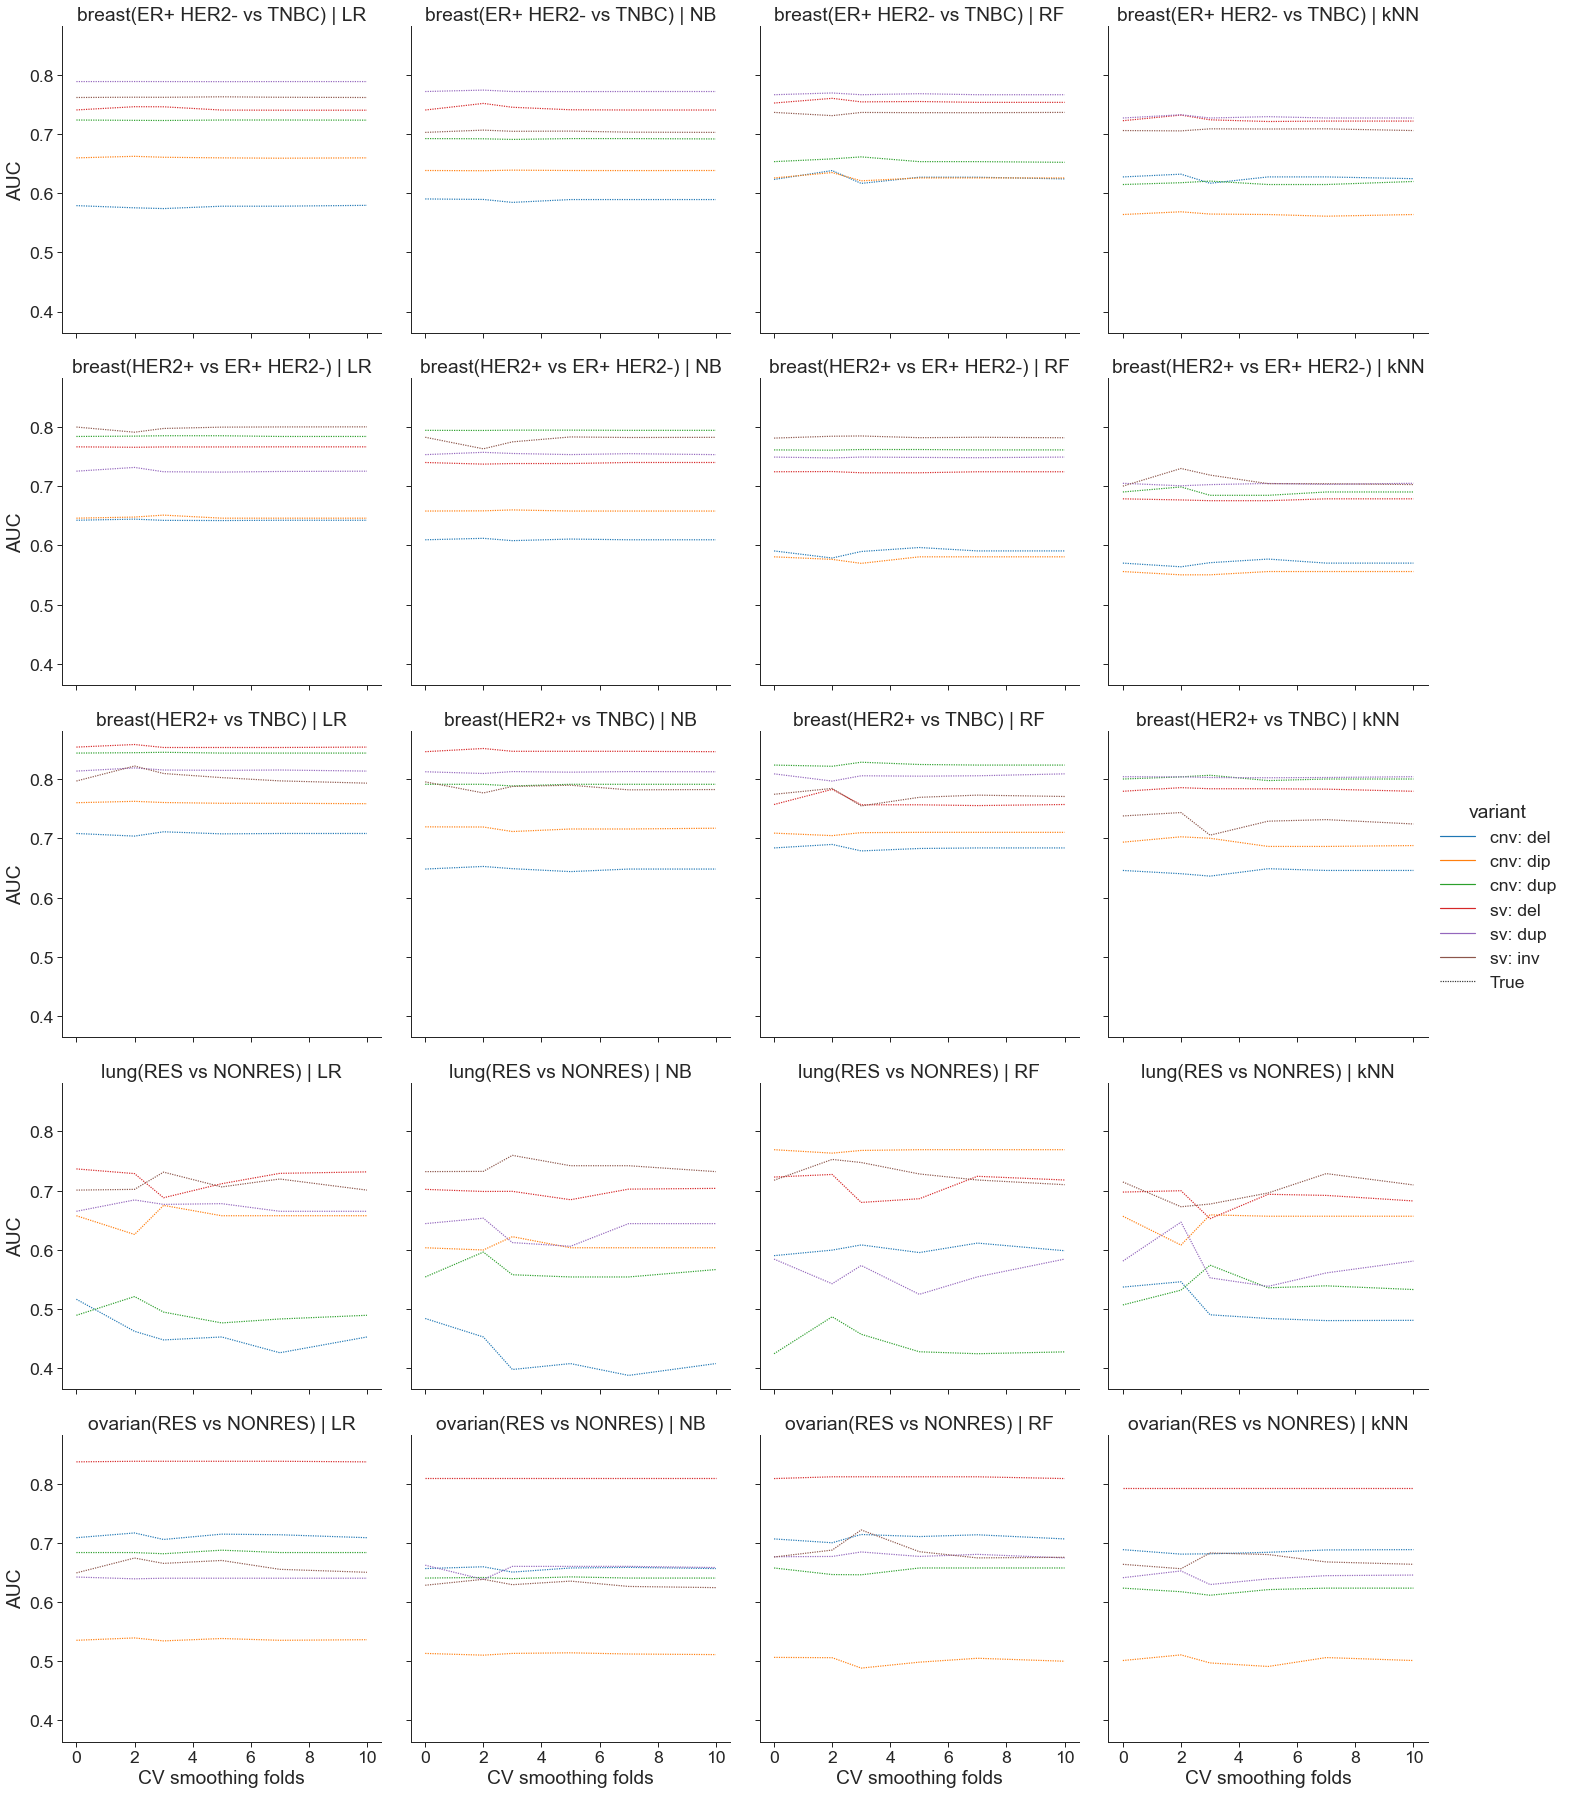

In [7]:
cv_smoothing_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index_col=None)
cv_smoothing_sensitivity_df.loc[cv_smoothing_sensitivity_df.cv == "None", "cv"] = "0"
cv_smoothing_sensitivity_df.loc[:, "cv"] = cv_smoothing_sensitivity_df.loc[:, "cv"].astype("int32")
cv_smoothing_sensitivity_df = cv_smoothing_sensitivity_df.rename(columns={"cv": "CV smoothing folds"})
plot_sensitivity_results(cv_smoothing_sensitivity_df, "CV smoothing folds", RESULTS_FOLDER, "cv", style=True, dashes=[(1,1)])

### Quantile and clustering: number of extracted features

The following set of experiments verifies the sensitivity of the proposed feature extraction methods to changing the number of produced features. In quantile binning, the effect of the number of quantiles was inspected. In the clustering approach, the impact of the number of clusters was measured.

In [17]:
param_name = "n_bins"
param_values = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50]
n_bins_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, 
                                                                                    ["quantile", "clustering"],
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    n_bins_sensitivity = n_bins_sensitivity.append(results_cancer_type)
    n_bins_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

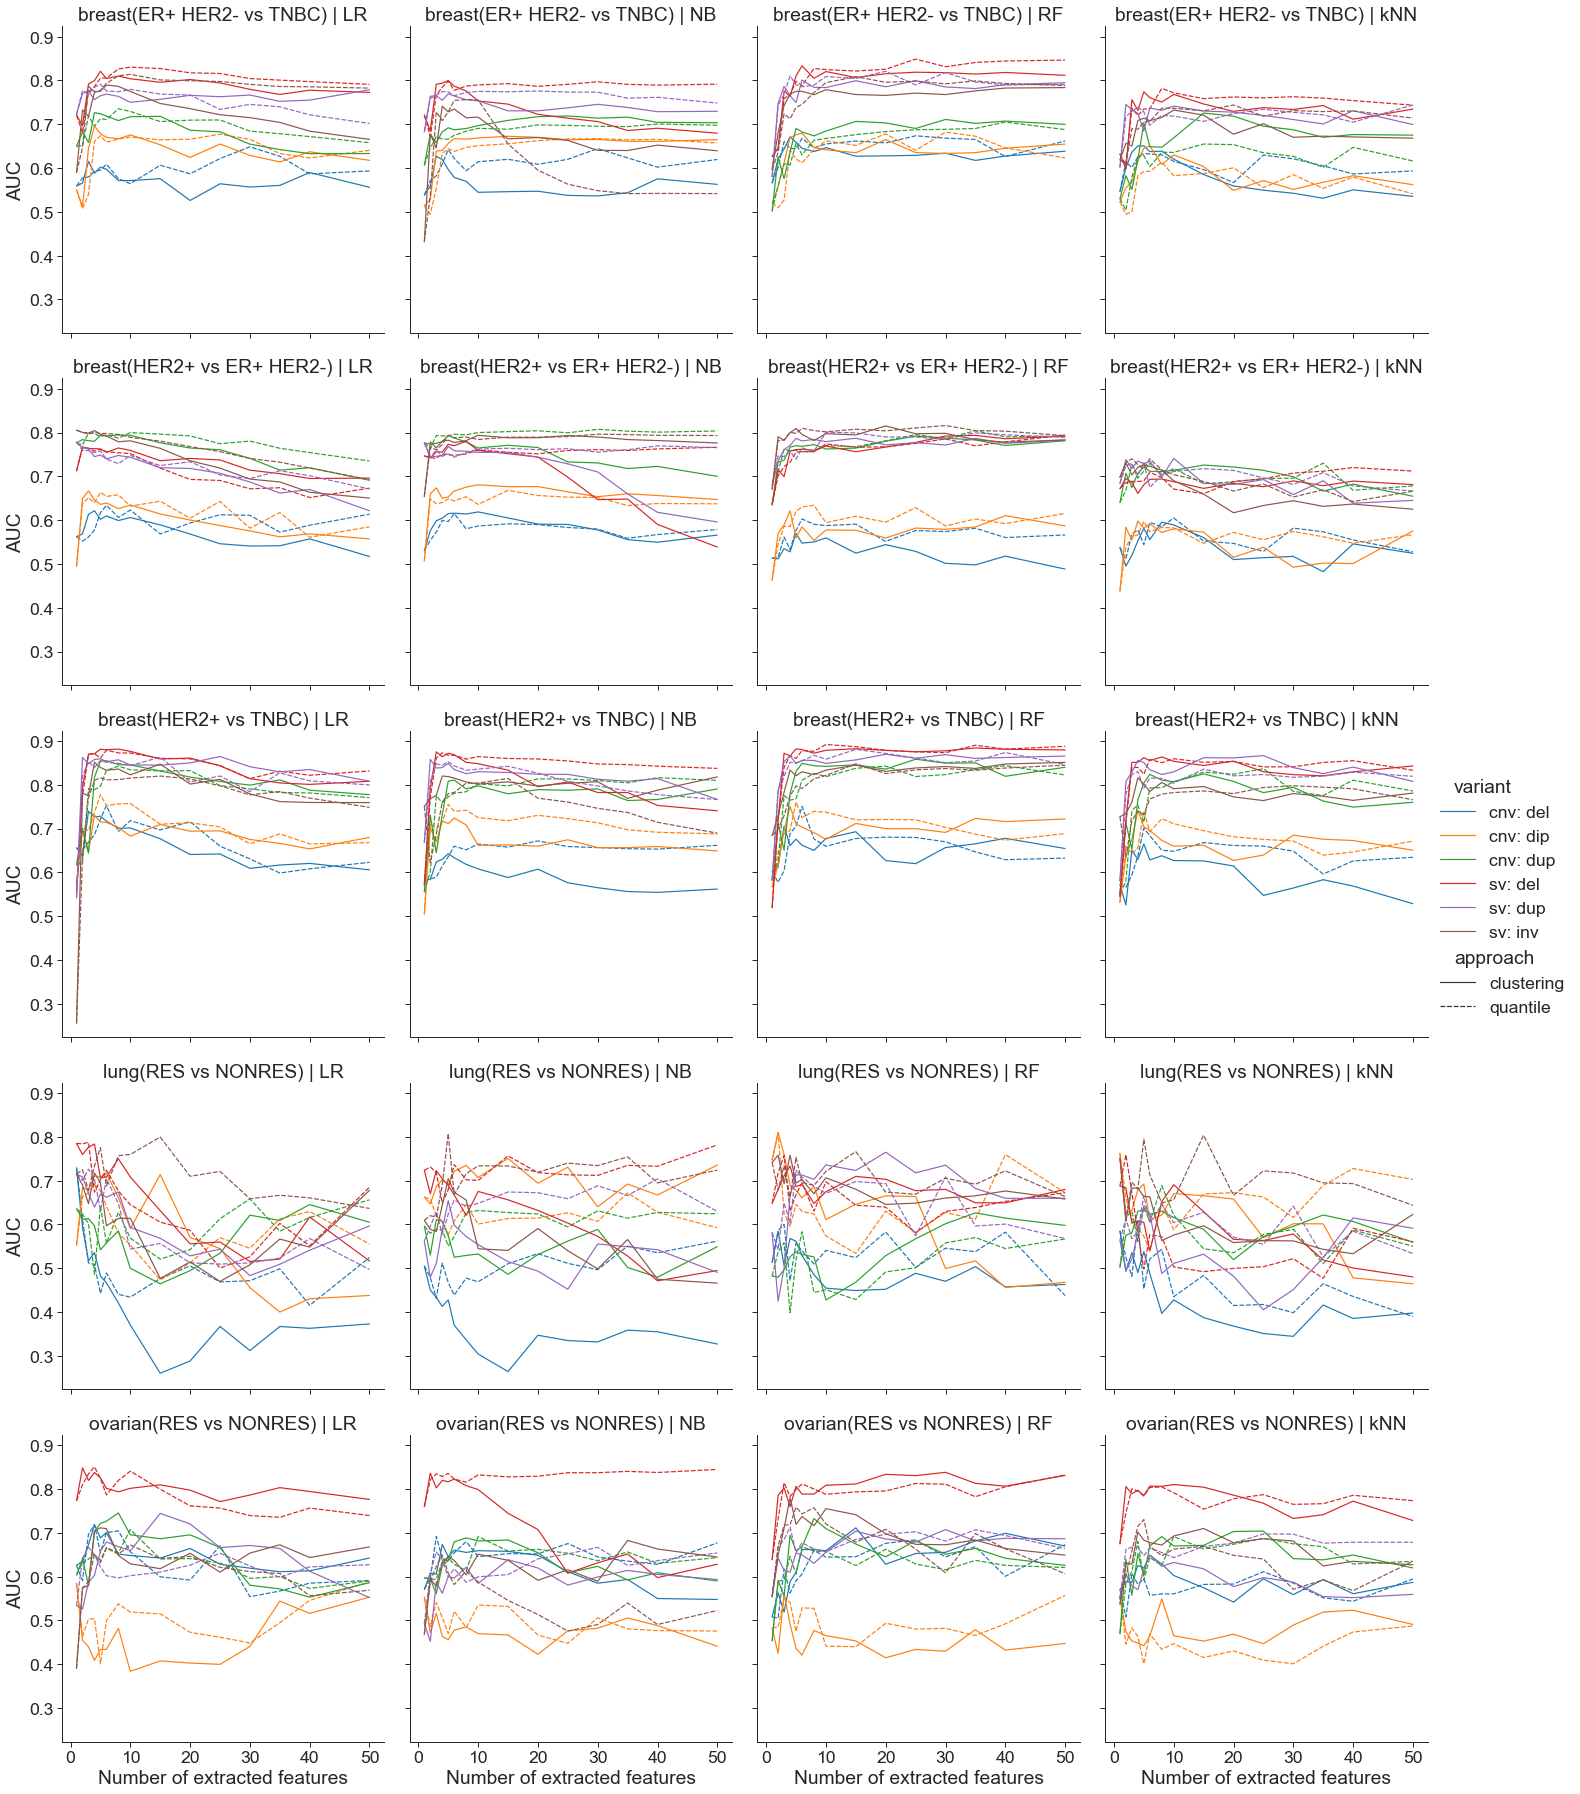

In [8]:
n_bins_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index_col=None)
n_bins_sensitivity_df = n_bins_sensitivity_df.rename(columns={"n_bins": "Number of extracted features"})
plot_sensitivity_results(n_bins_sensitivity_df, "Number of extracted features", RESULTS_FOLDER, "n_bins")

## Comparative evaluation on training and testing data

To evaluate the predictive performance of DBFE, we combined features of each variant type within a given approach. The parameters for each approach were chosen base on the sensitivity tests for each dataset. Moreover, we compared DBFE to PAM50 gene amplifications. As a result, for each dataset we compared the performance of the:

- quantile binning approach (sv+cnv)
- clustering approach (sv+cnv)
- supervised approach (sv+cnv)
- PAM50 amplifications (geneamps)
- quantile+PAM50 (sv+cnv+geneamps)
- clustering+PAM50 (sv+cnv+geneamps)
- supervised+PAM50 (sv+cnv+geneamps)


In [7]:
# Retrieving best parameters from sensitivity tests
n_bins_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index_col=None)
best_n_bins = get_best_cv_param(n_bins_sensitivity_df, "n_bins")

cv_smoothing_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index_col=None)
best_cv = get_best_cv_param(cv_smoothing_sensitivity_df, "cv")
best_cv = best_cv.fillna("None")

only_peaks_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index_col=None)
best_only_peaks = get_best_cv_param(only_peaks_sensitivity_df, "only_peaks")

bandwidth_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index_col=None)
best_bw = get_best_cv_param(bandwidth_sensitivity_df, "bw")

def best_params_dict(breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm):
    if breakpoint_type == "supervised":
        result = { 
            "n_bins": "auto",
            "only_peaks": best_param_value(best_only_peaks, "only_peaks", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
            "bw": best_param_value(best_bw, "bw", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
            "cv": best_param_value(best_cv, "cv", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
        }
        
        if result["cv"] != "None":
            result["cv"] = int(result["cv"])
        else:
            result["cv"] = None
            
        return result
    else:
        return {  
            "n_bins": int(best_param_value(best_n_bins, "n_bins", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm)),
        } 

### Holdout results

In [8]:
multivariant_holdout_results = pd.DataFrame()

results_cancer_type = Parallel(n_jobs=5)(delayed(multivariant_holdout_tests) (cancer, VARIANTS, ["quantile", "clustering", "supervised"],
                                                                              ALGORITHMS, best_params_dict)
                                         for cancer in CANCERS)
multivariant_holdout_results = multivariant_holdout_results.append(results_cancer_type)
multivariant_holdout_results.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results.csv'), index=False)

In [9]:
multivariant_holdout_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results.csv'), index_col=None)
results_df = multivariant_holdout_results_df
cancer_type_cat = pd.CategoricalDtype(categories=["ovarian", "lung", "breast"], ordered=True)
results_df.cancer_type = results_df.cancer_type.astype(cancer_type_cat)
classes_cat = pd.CategoricalDtype(categories=["RES vs NONRES", "HER2+ vs ER+ HER2-", "HER2+ vs TNBC", "ER+ HER2- vs TNBC"], ordered=True)
results_df.classes = results_df.classes.astype(classes_cat)
breakpoint_cat = pd.CategoricalDtype(categories=["quantile", "clustering", "supervised", "PAM50"], ordered=True)
results_df.breakpoint_type = results_df.breakpoint_type.astype(breakpoint_cat)
group_cat = pd.CategoricalDtype(categories=["sv+cnv", "geneamps", "sv+cnv+geneamps"], ordered=True)
results_df.variant_group = results_df.variant_group.astype(group_cat)

results_df = multivariant_holdout_results_df.groupby(["cancer_type", "classes", "algorithm", "variant_group", "breakpoint_type"]).mean().loc[:, ["AUROC", "features"]].round(3).reset_index()
results_df.loc[results_df.variant_group == "geneamps", "breakpoint_type"] = "PAM50"
results_df = results_df.drop_duplicates()
results_df = results_df.dropna()
results_pivot_df = results_df.pivot(index=["algorithm", "cancer_type", "classes"], columns=["variant_group", "breakpoint_type"], values=["AUROC"])
results_pivot_df.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results_formatted.csv'))
results_pivot_df

AUROC                        \
variant_group                              sv+cnv                         
breakpoint_type                          quantile clustering supervised   
algorithm cancer_type classes                                             
LR        ovarian     RES vs NONRES         0.671      0.855      0.626   
          lung        RES vs NONRES         0.450      0.538      0.412   
          breast      HER2+ vs ER+ HER2-    0.643      0.725      0.742   
                      HER2+ vs TNBC         0.932      0.906      0.960   
                      ER+ HER2- vs TNBC     0.883      0.895      0.927   
NB        ovarian     RES vs NONRES         0.630      0.660      0.736   
          lung        RES vs NONRES         0.525      0.638      0.337   
          breast      HER2+ vs ER+ HER2-    0.775      0.756      0.762   
                      HER2+ vs TNBC         0.917      0.896      0.943   
                      ER+ HER2- vs TNBC     0.716      0.848      0.867   
RF        ovarian     RES vs NONRES         0.788      0.761      0.768   
          lung        RES vs NONRES         0.412      0.412      0.462   
          breast      HER2+ vs ER+ HER2-    0.738      0.700      0.730   
                      HER2+ vs TNBC         0.943      0.940      0.948   
                      ER+ HER2- vs TNBC     0.892      0.902      0.905   
kNN       ovarian     RES vs NONRES         0.687      0.644      0.644   
          lung        RES vs NONRES         0.388      0.394      0.481   
          breast      HER2+ vs ER+ HER2-    0.721      0.719      0.658   
                      HER2+ vs TNBC         0.909      0.932      0.914   
                      ER+ HER2- vs TNBC     0.821      0.879      0.862   

                                                                              \
variant_group                            geneamps sv+cnv+geneamps              
breakpoint_type                             PAM50        quantile clustering   
algorithm cancer_type classes                                                  
LR        ovarian     RES vs NONRES         0.663           0.690      0.814   
          lung        RES vs NONRES         0.338           0.362      0.412   
          breast      HER2+ vs ER+ HER2-    0.946           0.854      0.909   
                      HER2+ vs TNBC         0.937           0.937      0.939   
                      ER+ HER2- vs TNBC     0.842           0.932      0.928   
NB        ovarian     RES vs NONRES         0.647           0.680      0.663   
          lung        RES vs NONRES         0.475           0.588      0.650   
          breast      HER2+ vs ER+ HER2-    0.952           0.916      0.941   
                      HER2+ vs TNBC         0.975           0.936      0.918   
                      ER+ HER2- vs TNBC     0.816           0.776      0.874   
RF        ovarian     RES vs NONRES         0.677           0.795      0.761   
          lung        RES vs NONRES         0.344           0.394      0.331   
          breast      HER2+ vs ER+ HER2-    1.000           0.997      0.998   
                      HER2+ vs TNBC         0.987           0.989      0.989   
                      ER+ HER2- vs TNBC     0.857           0.920      0.913   
kNN       ovarian     RES vs NONRES         0.624           0.680      0.681   
          lung        RES vs NONRES         0.212           0.494      0.700   
          breast      HER2+ vs ER+ HER2-    0.830           0.776      0.783   
                      HER2+ vs TNBC         0.764           0.964      0.970   
                      ER+ HER2- vs TNBC     0.735           0.830      0.860   

                                                     
variant_group                                        
breakpoint_type                          supervised  
algorithm cancer_type classes                        
LR        ovarian     RES vs NONRES           0.618  
          lung        RES vs NONRES           0.450 

Below we additionally present the number of features used by each approach.

In [63]:
features_pivot_df = results_df.pivot(index=["algorithm", "cancer_type", "classes"], columns=["variant_group", "breakpoint_type"], values=["features"])
features_pivot_df = features_pivot_df.astype("int")
features_pivot_df.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_features_formatted.csv'))
features_pivot_df

features                        \
variant_group                              sv+cnv                         
breakpoint_type                          quantile clustering supervised   
algorithm cancer_type classes                                             
LR        ovarian     RES vs NONRES           224        198         48   
          lung        RES vs NONRES            34         38         90   
          breast      HER2+ vs ER+ HER2-      172         74         46   
                      HER2+ vs TNBC           106        108         36   
                      ER+ HER2- vs TNBC       218        180         50   
NB        ovarian     RES vs NONRES           128         98         50   
          lung        RES vs NONRES           106         84        178   
          breast      HER2+ vs ER+ HER2-      216        104         48   
                      HER2+ vs TNBC           200        268         36   
                      ER+ HER2- vs TNBC       228         64         36   
RF        ovarian     RES vs NONRES           132        142         34   
          lung        RES vs NONRES           102         88        142   
          breast      HER2+ vs ER+ HER2-      366        206         62   
                      HER2+ vs TNBC           242        284         50   
                      ER+ HER2- vs TNBC       174        150         56   
kNN       ovarian     RES vs NONRES           172         66         52   
          lung        RES vs NONRES            42         50         90   
          breast      HER2+ vs ER+ HER2-      190         94         42   
                      HER2+ vs TNBC           188         86         36   
                      ER+ HER2- vs TNBC       188        144         56   

                                                                              \
variant_group                            geneamps sv+cnv+geneamps              
breakpoint_type                             PAM50        quantile clustering   
algorithm cancer_type classes                                                  
LR        ovarian     RES vs NONRES            50             274        248   
          lung        RES vs NONRES            50              84         88   
          breast      HER2+ vs ER+ HER2-       50             222        124   
                      HER2+ vs TNBC            50             156        158   
                      ER+ HER2- vs TNBC        50             268        230   
NB        ovarian     RES vs NONRES            50             178        148   
          lung        RES vs NONRES            50             156        134   
          breast      HER2+ vs ER+ HER2-       50             266        154   
                      HER2+ vs TNBC            50             250        318   
                      ER+ HER2- vs TNBC        50             278        114   
RF        ovarian     RES vs NONRES            50             182        192   
          lung        RES vs NONRES            50             152        138   
          breast      HER2+ vs ER+ HER2-       50             416        256   
                      HER2+ vs TNBC            50             292        334   
                      ER+ HER2- vs TNBC        50             224        200   
kNN       ovarian     RES vs NONRES            50             222        116   
          lung        RES vs NONRES            50              92        100   
          breast      HER2+ vs ER+ HER2-       50             240        144   
                      HER2+ vs TNBC            50             238        136   
                      ER+ HER2- vs TNBC        50             238        194   

                                                     
variant_group                                        
breakpoint_type                          supervised  
algorithm cancer_type classes                        
LR        ovarian     RES vs NONRES              98  
          lung        RES vs NONRES             1

### Features designed by a human expert

Below is the list of features designed by a human expert for ovarian cancer data and the corresponding holdout results.

In [3]:
EXPERT_VARIANTS = [('cnv', 'del', [(0, 30), (30, 3500), (3500, 100000), (100000, np.inf)]), 
                   ('cnv', 'dip', [(0, 30), (30, 500), (500, 100000), (100000, np.inf)]),
                   ('cnv', 'dup', [(0, 30), (30, 100), (100, 350), (350, 3000), (3000, 25000), (25000, np.inf)]),
                   ('sv', 'del', [(0, 30), (30, 3500), (3500, 100000), (100000, np.inf)]), 
                   ('sv', 'dup', [(0, 30), (30, 100), (100, 1000), (1000, 30000), (30000, np.inf)])]

In [4]:
human_expert_results = human_expert_tests(('ovarian', ['RES', 'NONRES']), EXPERT_VARIANTS, ALGORITHMS)
human_expert_results.to_csv(os.path.join(RESULTS_FOLDER, 'human_expert_results.csv'), index=False)

In [5]:
human_expert_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'human_expert_results.csv'), index_col=None)
human_expert_results_df.round(3)

Accuracy  Precision  Recall     F1  AUROC  Kappa    MCC  Balanced accuracy  \
0     0.750      0.923   0.545  0.686  0.784  0.500  0.548              0.750   
1     0.636      0.650   0.591  0.619  0.674  0.273  0.274              0.636   
2     0.614      0.619   0.591  0.605  0.653  0.227  0.228              0.614   
3     0.636      0.688   0.500  0.579  0.700  0.273  0.283              0.636   

  algorithm  features cancer_type        classes pos_class variant_group  \
0        RF        23     ovarian  RES vs NONRES       RES        expert   
1        NB        23     ovarian  RES vs NONRES       RES        expert   
2        LR        23     ovarian  RES vs NONRES       RES        expert   
3       kNN        23     ovarian  RES vs NONRES       RES        expert   

   variant_type breakpoint_type  
0           NaN          expert  
1           NaN          expert  
2           NaN          expert  
3           NaN          expert

## Feature importance comparison

We also analyzed how DBFE feature fare against gene amplifications in terms of feature importance by calculating the ANOVA F-test. FOr each dataset, we show the top 10 most important features.

In [ ]:
feature_importance_results = pd.DataFrame()

results_cancer_type = Parallel(n_jobs=5)(delayed(feature_importance_tests) (cancer, VARIANTS, ["quantile", "clustering", "supervised"],
                                                                              ALGORITHMS, best_params_dict)
                                         for cancer in CANCERS)
feature_importance_results = feature_importance_results.append(results_cancer_type)
feature_importance_results.to_csv(os.path.join(RESULTS_FOLDER, 'feature_importance_results.csv'), index=False)

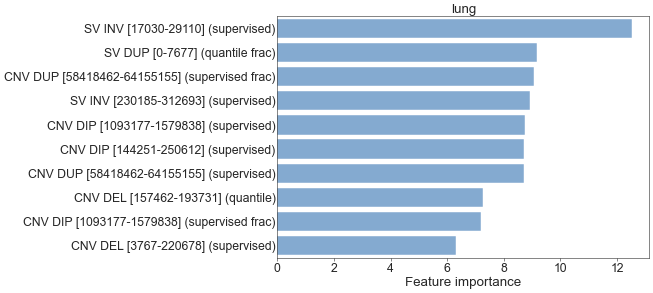

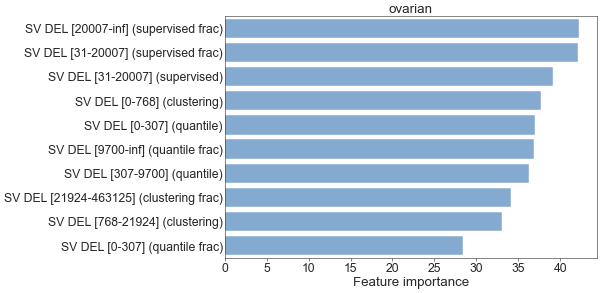

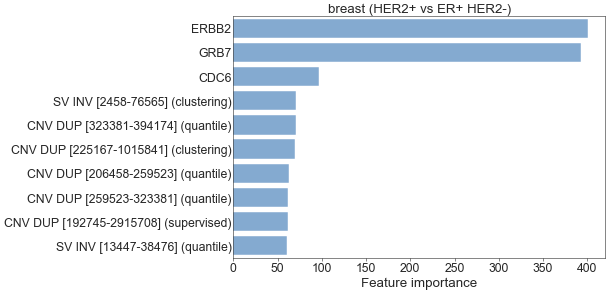

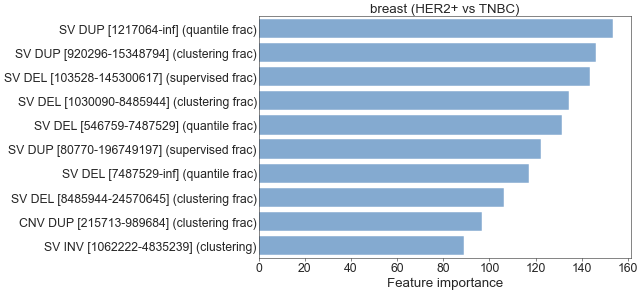

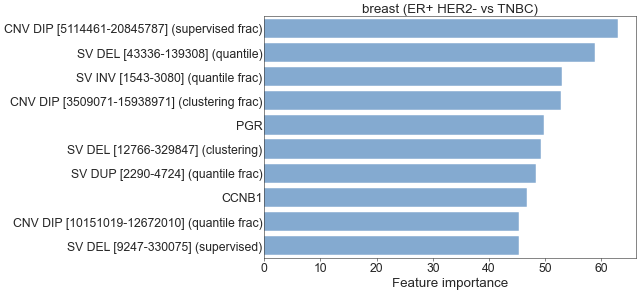

In [34]:
feature_importance_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'feature_importance_results.csv'), index_col=None)
plt.rcParams['figure.dpi'] = 40

for cancer in CANCERS:
    allowed_classes, cancer_type, class_labels, pos_class, _, __ = extract_cancer_varaint(cancer, (None, None))
    plot_name = cancer_type + "_" + class_labels.replace(" ", "_")
    
    plot_feature_importance(feature_importance_results_df, cancer_type, class_labels, plot_name, RESULTS_FOLDER)

## Clustering

Since the quantile binning and clustering approaches can generate features without class labels, we verified if these approaches can be used to perform interpretable cluster analyses. For this purpose we used the breast cancer dataset, which consists of 811 samples and would be the most difficult to analyze manually.

### Quantile binning approach

First we generated four quantile bins for each variant type and pro-duced a total of 54 DBFE features (6 variant types x (4 count features + 4 fraction features + 1 total count)). Based on these features, we created a 2D plot using UMAP dimensionality reduction .

In [3]:
breast_quantile_df = get_breast_clustering_data("quantile", VARIANTS, SEED)
breast_quantile_df.to_csv(os.path.join(RESULTS_FOLDER, "Clusters_quantile.csv"))

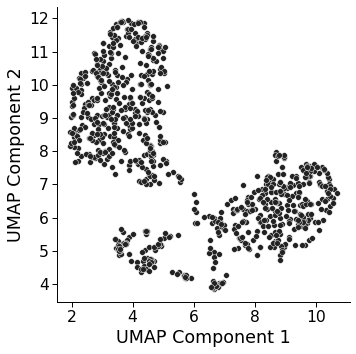

In [4]:
breast_quantile_df = pd.read_csv(os.path.join(RESULTS_FOLDER, "Clusters_quantile.csv"), index_col=0)
plt.rcParams['figure.dpi'] = 70
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_umap")

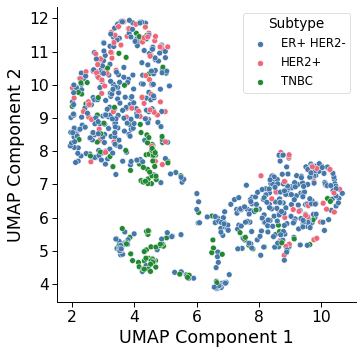

In [5]:
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_subtype", hue="Subtype", palette=SUBTYPE_COLORS)

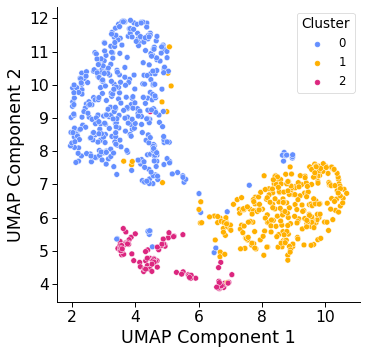

In [6]:
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_clusters", hue="Cluster", palette=CLUSTER_COLORS)

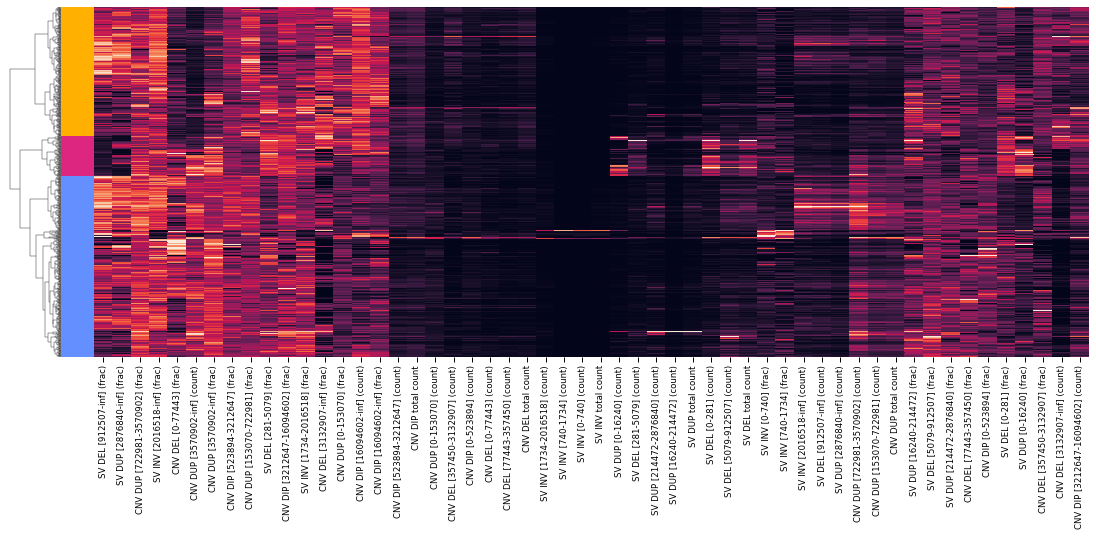

In [7]:
create_clustergram(breast_quantile_df, RESULTS_FOLDER, "quantile_clustergram", COLOR_MAPPING)

### Clustering approach

The same analysis was performed using the clustering approach, yielding similar results.

In [8]:
breast_clustering_df = get_breast_clustering_data("clustering", VARIANTS, SEED)
breast_clustering_df.to_csv(os.path.join(RESULTS_FOLDER, "Clusters_clustering.csv"))

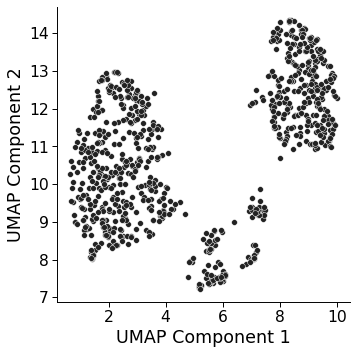

In [9]:
breast_clustering_df = pd.read_csv(os.path.join(RESULTS_FOLDER, "Clusters_clustering.csv"), index_col=0)
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_umap")

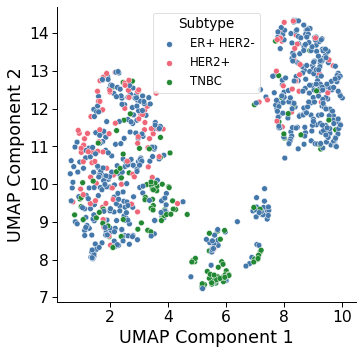

In [10]:
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_subtype", hue="Subtype", palette=SUBTYPE_COLORS)

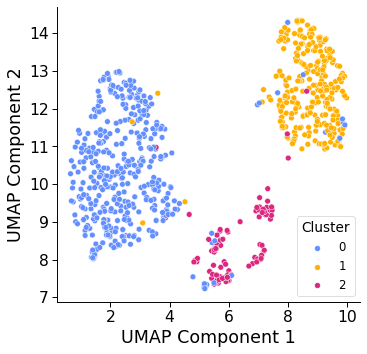

In [11]:
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_clusters", hue="Cluster", palette=CLUSTER_COLORS)

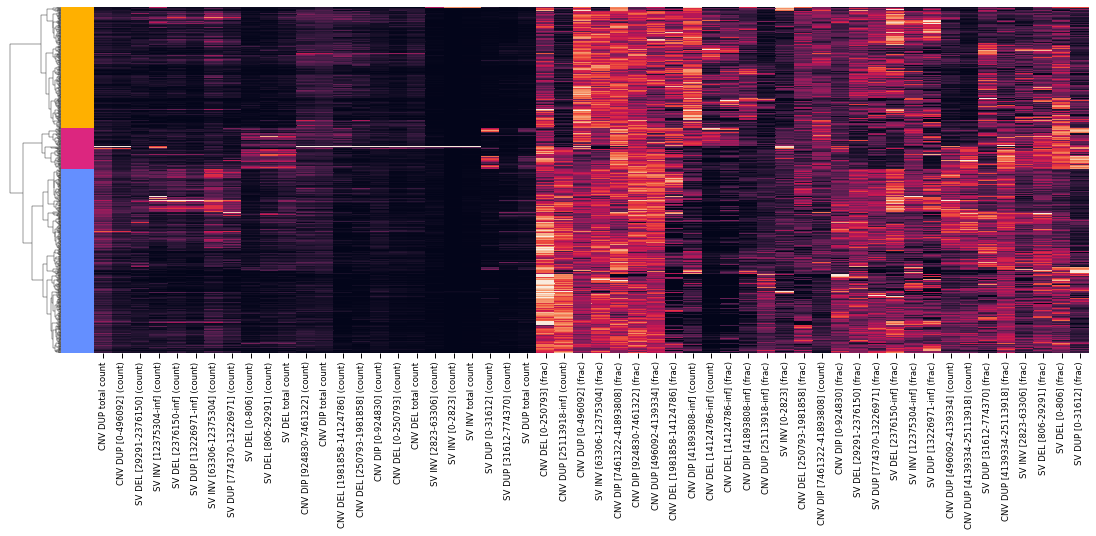

In [12]:
create_clustergram(breast_clustering_df, RESULTS_FOLDER, "clustering_clustergram", COLOR_MAPPING)